Time Series Forecasting Tool
Loaded 64 data points from 65 input years
Data range: 1960 to 2023
ADF Statistic: -1.6299
p-value: 0.4675
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (2, 2, 3)
AIC: 698.64

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   1099.04      896.35       1301.73     
2026   1077.56      822.61       1332.50     
2027   1102.10      805.85       1398.35     
2028   1105.62      764.72       1446.52     
2029   1113.66      739.99       1487.34     
2030   1126.48      715.45       1537.51     
2031   1130.53      689.09       1571.96     
2032   1143.92      670.35       1617.50     
2033   1149.26      646.54       1651.98     
2034   nan          nan          nan         


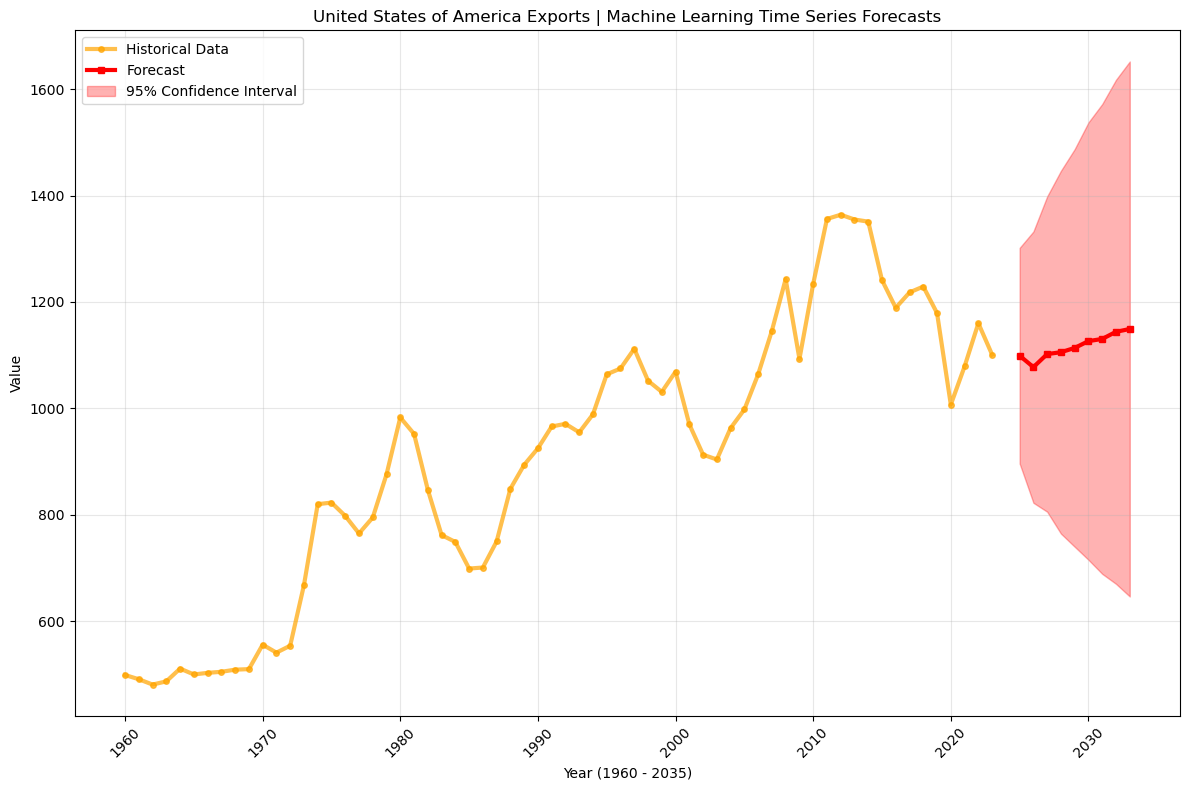

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -343.319
Date:                Fri, 25 Jul 2025   AIC                            698.639
Time:                        18:07:06   BIC                            711.401
Sample:                    01-01-1960   HQIC                           703.650
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3474      0.135    -10.015      0.000      -1.611      -1.084
ar.L2         -0.5171      0.131     -3.940      0.000      -0.774      -0.260
ma.L1          0.8041     12.919      0.062      0.9

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('United States of America Exports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("Forecast Predictions (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA EXPORTS
    sample_data = {
        1960:4.99, 1961:4.91, 1962:4.81, 1963:4.87, 1964:5.11,
        1965:5.00, 1966:5.03, 1967:5.05, 1968:5.09, 1969:5.10,
        1970:5.56, 1971:5.41, 1972:5.54, 1973:6.68, 1974:8.20,
        1975:8.23, 1976:7.98, 1977:7.65, 1978:7.95, 1979:8.76,
        1980:9.83, 1981:9.52, 1982:8.47, 1983:7.62, 1984:7.49,
        1985:6.99, 1986:7.01, 1987:7.50, 1988:8.49, 1989:8.94,
        1990:9.25, 1991:9.66, 1992:9.71, 1993:9.55, 1994:9.89,
        1995:10.64, 1996:10.75, 1997:11.12, 1998:10.52, 1999:10.31,
        2000:10.69, 2001:9.70, 2002:9.13, 2003:9.04, 2004:9.63,
        2005:9.98, 2006:10.64, 2007:11.46, 2008:12.43, 2009:10.93,
        2010:12.34, 2011:13.56, 2012:13.64, 2013:13.55, 2014:13.51,
        2015:12.41, 2016:11.89, 2017:12.18, 2018:12.29, 2019:11.79,
        2020:10.07, 2021:10.79, 2022:11.60, 2023:11.01, 2024:10.90
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Enhanced Time Series Forecasting Tool with Econometric Analysis
Loaded 65 data points from 65 input years
Data range: 1960 to 2024

STATIONARITY ANALYSIS
Augmented Dickey-Fuller Test:
  ADF Statistic: -1.6213
  p-value: 0.4721
  Critical Values: {'1%': -3.540522678829176, '5%': -2.9094272025108254, '10%': -2.5923136524453696}

KPSS Test:
  KPSS Statistic: 1.0352
  p-value: 0.0100
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

⚠ Series is NON-STATIONARY (both tests agree)

MODEL SELECTION AND EVALUATION
Testing ARIMA models...
Testing SARIMA models...
Testing Exponential Smoothing...

Selected Model: EXP_SMOOTHING
AIC: -49.97

COMPREHENSIVE ECONOMETRIC ANALYSIS

1. PARAMETER SIGNIFICANCE ANALYSIS
--------------------------------------------------

2. RESIDUAL ANALYSIS
--------------------------------------------------
Jarque-Bera Normality Test:
  Statistic: 1.4247, p-value: 0.4905
  ✓ Residuals are normally distributed

Ljung-Box Autocorrelation Test (lag 1

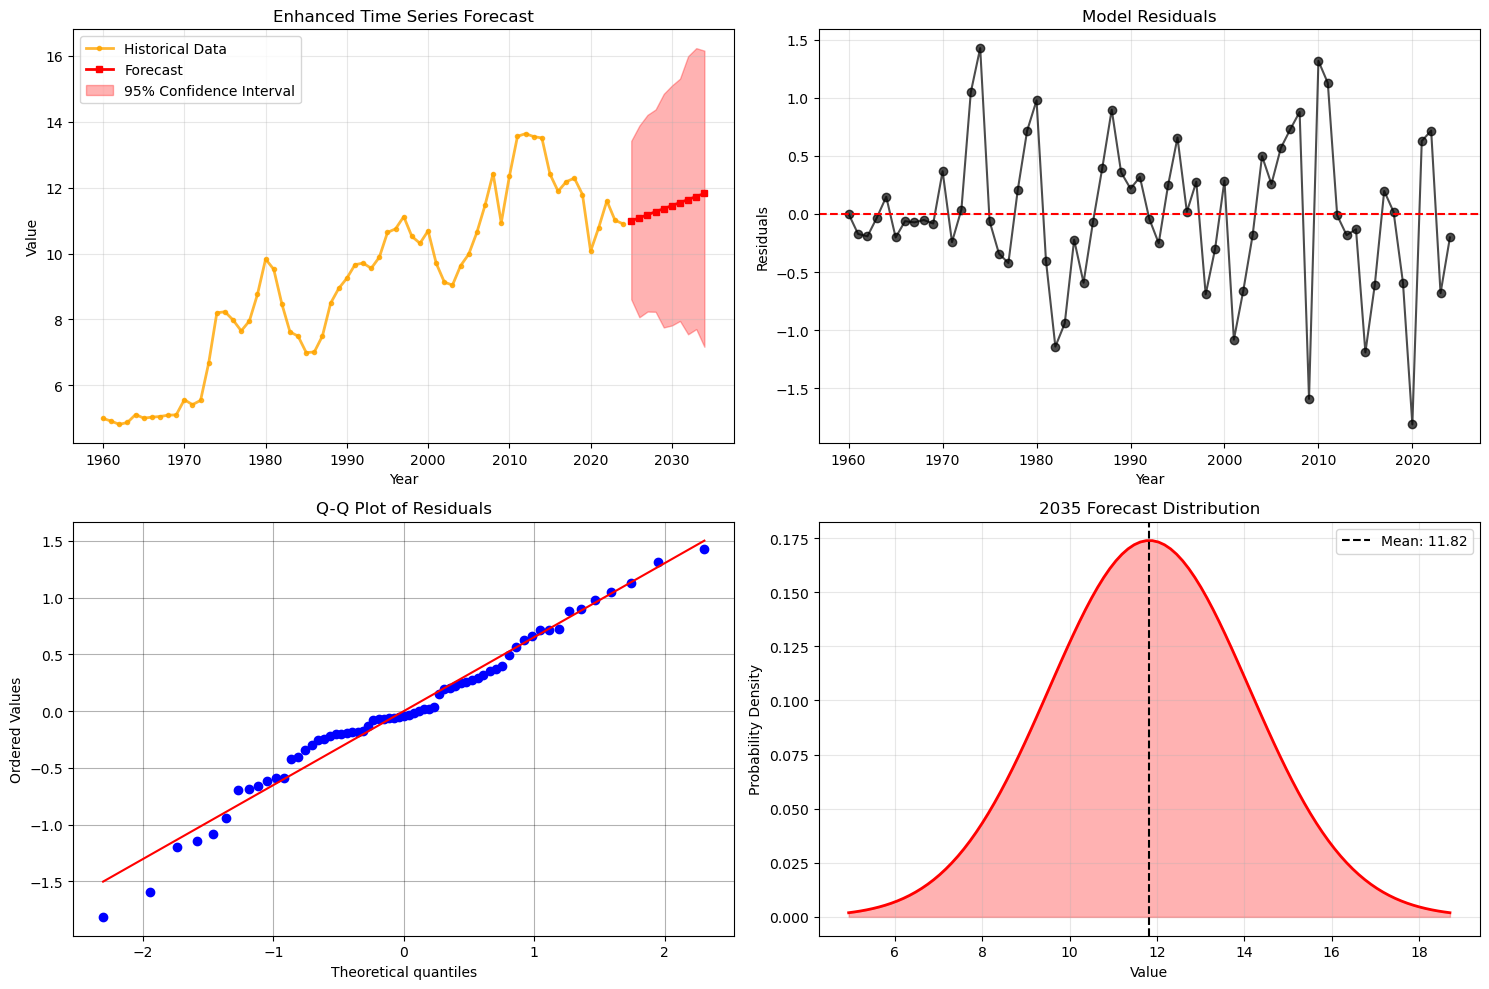

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

class EnhancedTimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2025)  # Extended to include 2024
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        # Calculating additional features for volatility modeling
        self.returns = self.clean_data.pct_change().dropna()
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def comprehensive_stationarity_tests(self):
        """Perform multiple stationarity tests"""
        print("\n" + "="*60)
        print("STATIONARITY ANALYSIS")
        print("="*60)
        
        # ADF Test
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller Test:")
        print(f"  ADF Statistic: {adf_result[0]:.4f}")
        print(f"  p-value: {adf_result[1]:.4f}")
        print(f"  Critical Values: {adf_result[4]}")
        
        # KPSS Test
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\nKPSS Test:")
        print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"  p-value: {kpss_result[1]:.4f}")
        print(f"  Critical Values: {kpss_result[3]}")
        
        # Interpretation
        adf_stationary = adf_result[1] <= 0.05
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n✓ Series is STATIONARY (both tests agree)")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n⚠ Series is NON-STATIONARY (both tests agree)")
            return False, 1
        else:
            print("\n⚠ Tests disagree - will use differencing")
            return False, 1
    
    def enhanced_model_selection(self):
        """
        Compare multiple models: ARIMA, SARIMA, and Exponential Smoothing
        Uses information criteria and cross-validation
        """
        print("\n" + "="*60)
        print("MODEL SELECTION AND EVALUATION")
        print("="*60)
        
        models = {}
        
        # 1. Auto ARIMA with extended search
        print("Testing ARIMA models...")
        best_arima = self._auto_arima_extended()
        if best_arima:
            models['ARIMA'] = best_arima
        
        # 2. SARIMA models
        print("Testing SARIMA models...")
        best_sarima = self._auto_sarima()
        if best_sarima:
            models['SARIMA'] = best_sarima
        
        # 3. Exponential Smoothing
        print("Testing Exponential Smoothing...")
        best_exp = self._exponential_smoothing()
        if best_exp:
            models['EXP_SMOOTHING'] = best_exp
        
        # Selecting the best model based on AIC and out-of-sample performance
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        
        print(f"\nSelected Model: {self.best_model_type}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def _auto_arima_extended(self, max_p=5, max_d=2, max_q=5):
        """Extended ARIMA model search"""
        best_aic = np.inf
        best_model = None
        best_params = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        return {'model': best_model, 'params': best_params, 'type': 'ARIMA'} if best_model else None
    
    def _auto_sarima(self):
        """Test SARIMA models with seasonal components"""
        best_aic = np.inf
        best_model = None
        best_params = None
        
        # Testing common seasonal patterns
        seasonal_orders = [(1,1,1,12), (0,1,1,12), (1,1,0,12)]
        
        for seasonal_order in seasonal_orders:
            for p in range(3):
                for d in range(2):
                    for q in range(3):
                        try:
                            model = SARIMAX(self.clean_data, 
                                          order=(p, d, q),
                                          seasonal_order=seasonal_order)
                            fitted_model = model.fit(disp=False)
                            
                            if fitted_model.aic < best_aic:
                                best_aic = fitted_model.aic
                                best_params = ((p, d, q), seasonal_order)
                                best_model = fitted_model
                                
                        except Exception:
                            continue
        
        return {'model': best_model, 'params': best_params, 'type': 'SARIMA'} if best_model else None
    
    def _exponential_smoothing(self):
        """Exponential Smoothing with trend and seasonality"""
        try:
            model = ExponentialSmoothing(self.clean_data, 
                                       trend='add', 
                                       seasonal=None,
                                       seasonal_periods=None)
            fitted_model = model.fit()
            return {'model': fitted_model, 'params': 'ETS(A,A,N)', 'type': 'EXP_SMOOTHING'}
        except Exception:
            return None
    
    def _select_best_model(self, models):
        """Select best model based on AIC and validation"""
        if not models:
            raise ValueError("No valid models found")
        
        best_model = None
        best_aic = np.inf
        
        for model_name, model_info in models.items():
            try:
                aic = model_info['model'].aic
                if aic < best_aic:
                    best_aic = aic
                    best_model = model_info
            except AttributeError:
                # Handling the models without AIC (like ExponentialSmoothing)
                continue
        
        return best_model if best_model else list(models.values())[0]
    
    def estimate_volatility(self):
        """Estimate volatility using GARCH-like approach"""
        residuals = self.model.resid
        
        # volatility estimation
        rolling_std = residuals.rolling(window=5).std()
        volatility = rolling_std.iloc[-1] if not pd.isna(rolling_std.iloc[-1]) else residuals.std()
        
        return volatility
    
    def forecast_with_volatility(self, years_ahead=10, n_simulations=1000):
        """Generate forecasts incorporating volatility"""
        if self.model is None:
            raise ValueError("Model not fitted. Call enhanced_model_selection() first.")
        
        # base forecast
        if self.best_model_type == 'EXP_SMOOTHING':
            forecast_result = self.model.forecast(steps=years_ahead)
            # create dummy confidence intervals for exponential smoothing
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
        else:
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            forecast_result = forecast_obj.predicted_mean
            forecast_std = forecast_obj.se_mean
        
        # Estimate volatility
        volatility = self.estimate_volatility()
        
        # Monte Carlo simulation for more realistic confidence intervals
        simulations = []
        for _ in range(n_simulations):
            # Add volatility clustering
            vol_shocks = np.random.normal(0, volatility, years_ahead)
            trend_shocks = np.random.normal(0, forecast_std)
            simulated_path = forecast_result + trend_shocks + vol_shocks
            simulations.append(simulated_path)
        
        simulations = np.array(simulations)
        
        # Calculate percentiles for confidence intervals
        forecast_lower = np.percentile(simulations, 2.5, axis=0)
        forecast_upper = np.percentile(simulations, 97.5, axis=0)
        
        # forecast dates (2026-2035)
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Store results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(forecast_lower, index=forecast_index)
        self.forecast_upper = pd.Series(forecast_upper, index=forecast_index)
        self.volatility = volatility
        
        return self.forecast
    
    def econometric_analysis(self):
        """Comprehensive econometric analysis with p-values and statistics"""
        if self.model is None:
            raise ValueError("Model not fitted.")
        
        print("\n" + "="*80)
        print("COMPREHENSIVE ECONOMETRIC ANALYSIS")
        print("="*80)
        
        # 1. Model Parameters and Significance
        self._parameter_analysis()
        
        # 2. Residual Analysis
        self._residual_analysis()
        
        # 3. Forecast Accuracy Metrics
        self._forecast_accuracy()
        
        # 4. Probability Analysis
        self._probability_analysis()
        
        # 5. Economic Interpretation
        self._economic_interpretation()
    
    def _parameter_analysis(self):
        """Analyze model parameters and their significance"""
        print("\n1. PARAMETER SIGNIFICANCE ANALYSIS")
        print("-" * 50)
        
        if hasattr(self.model, 'pvalues'):
            params = self.model.params
            pvalues = self.model.pvalues
            std_errors = self.model.bse
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}")
            print("-" * 65)
            
            for param_name, param_val in params.items():
                p_val = pvalues[param_name]
                std_err = std_errors[param_name]
                
                if p_val < 0.01:
                    significance = "***"
                elif p_val < 0.05:
                    significance = "**"
                elif p_val < 0.10:
                    significance = "*"
                else:
                    significance = ""
                
                print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
    
    def _residual_analysis(self):
        """Analyze model residuals"""
        print("\n2. RESIDUAL ANALYSIS")
        print("-" * 50)
        
        residuals = self.model.resid
        
        # Normality test
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=True).iloc[-1]
        print(f"\nLjung-Box Autocorrelation Test (lag 10):")
        print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")
    
    def _forecast_accuracy(self):
        """Calculate forecast accuracy metrics"""
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 50)
        
        fitted_values = self.model.fittedvalues
        actual_values = self.clean_data[fitted_values.index]
        
        # Calculate the metrics
        mae = np.mean(np.abs(actual_values - fitted_values))
        mse = np.mean((actual_values - fitted_values)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
        
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
        
        if hasattr(self.model, 'aic'):
            print(f"Akaike Information Criterion (AIC): {self.model.aic:.2f}")
        if hasattr(self.model, 'bic'):
            print(f"Bayesian Information Criterion (BIC): {self.model.bic:.2f}")
        if hasattr(self.model, 'llf'):
            print(f"Log-Likelihood: {self.model.llf:.2f}")
    
    def _probability_analysis(self):
        """Probability analysis for forecasts"""
        print("\n4. FORECAST PROBABILITY ANALYSIS")
        print("-" * 50)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # Calculate probability of different scenarios
        forecast_mean = self.forecast.mean()
        forecast_std = (self.forecast_upper - self.forecast_lower).mean() / (2 * 1.96)  # Approximate std from CI
        
        # Probability calculations
        prob_increase = stats.norm.sf(self.clean_data.iloc[-1], forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        # Probability of different growth rates
        current_value = self.clean_data.iloc[-1]
        growth_rates = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20%
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2026-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        print(f"\nProbability of Growth Scenarios (by 2035):")
        print(f"{'Growth Rate':<12} {'Target Value':<12} {'Probability':<12}")
        print("-" * 40)
        
        for rate in growth_rates:
            target_value = current_value * (1 + rate)**11  # 11 years from 2024 to 2035
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            print(f"{rate*100:>6.0f}%      {target_value:>10.2f}      {prob:>8.3f} ({prob*100:.1f}%)")
    
    def _economic_interpretation(self):
        """Economic interpretation of results"""
        print("\n5. ECONOMIC INTERPRETATION")
        print("-" * 50)
        
        if self.forecast is None:
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        
        # Calculate compound annual growth rate
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {((forecast_2035/current_value-1)*100):.1f}%")
        print(f"Volatility Estimate: {self.volatility:.4f}")
        
        # Trend analysis
        if cagr > 0.03:
            trend = "Strong Growth"
        elif cagr > 0.01:
            trend = "Moderate Growth"
        elif cagr > -0.01:
            trend = "Stable"
        else:
            trend = "Declining"
        
        print(f"Overall Trend Classification: {trend}")
    
    def plot_enhanced_results(self, figsize=(15, 10)):
        """Enhanced plotting with multiple subplots"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main forecast plot
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.8, linewidth=2, markersize=3)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=2, markersize=4)
            
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        ax1.set_title('Enhanced Time Series Forecast')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Residuals plot
        ax2 = axes[0, 1]
        residuals = self.model.resid
        ax2.plot(residuals.index, residuals.values, 'o-', color='black', alpha=0.7)
        ax2.axhline(y=0, color='red', linestyle='--')
        ax2.set_title('Model Residuals')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        ax3 = axes[1, 0]
        stats.probplot(residuals, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot of Residuals')
        ax3.grid(True, color='black', alpha=0.3)
        
        # Forecast distribution for 2035
        ax4 = axes[1, 1]
        if self.forecast is not None:
            forecast_2035 = self.forecast.iloc[-1]
            forecast_std = (self.forecast_upper.iloc[-1] - self.forecast_lower.iloc[-1]) / (2 * 1.96)
            
            x = np.linspace(forecast_2035 - 3*forecast_std, forecast_2035 + 3*forecast_std, 100)
            y = stats.norm.pdf(x, forecast_2035, forecast_std)
            
            ax4.plot(x, y, 'r-', linewidth=2)
            ax4.fill_between(x, 0, y, alpha=0.3, color='red')
            ax4.axvline(forecast_2035, color='black', linestyle='--', label=f'Mean: {forecast_2035:.2f}')
            ax4.set_title('2035 Forecast Distribution')
            ax4.set_xlabel('Value')
            ax4.set_ylabel('Probability Density')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_enhanced_forecast_table(self):
        """Enhanced forecast table with probabilities"""
        if self.forecast is None:
            print("No forecast available.")
            return
            
        print("\n" + "="*80)
        print("Machine Learning Forecasts Analysis")
        print("="*80)
        print(f"{'Year':<6} {'Forecast':<10} {'Lower 95%':<10} {'Upper 95%':<10} {'Std Dev':<10} {'Growth %':<10}")
        print("-"*80)
        
        current_value = self.clean_data.iloc[-1]
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            lower_val = self.forecast_lower.iloc[i]
            upper_val = self.forecast_upper.iloc[i]
            std_dev = (upper_val - lower_val) / (2 * 1.96)
            
            if i == 0:
                growth = (forecast_val / current_value - 1) * 100
            else:
                growth = (forecast_val / self.forecast.iloc[i-1] - 1) * 100
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {lower_val:<10.2f} {upper_val:<10.2f} "
                  f"{std_dev:<10.4f} {growth:<10.2f}")
        
        print("="*80)


# Usage Instructions and Example
if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA EXPORTS
    sample_data = {
        1960:4.99, 1961:4.91, 1962:4.81, 1963:4.87, 1964:5.11,
        1965:5.00, 1966:5.03, 1967:5.05, 1968:5.09, 1969:5.10,
        1970:5.56, 1971:5.41, 1972:5.54, 1973:6.68, 1974:8.20,
        1975:8.23, 1976:7.98, 1977:7.65, 1978:7.95, 1979:8.76,
        1980:9.83, 1981:9.52, 1982:8.47, 1983:7.62, 1984:7.49,
        1985:6.99, 1986:7.01, 1987:7.50, 1988:8.49, 1989:8.94,
        1990:9.25, 1991:9.66, 1992:9.71, 1993:9.55, 1994:9.89,
        1995:10.64, 1996:10.75, 1997:11.12, 1998:10.52, 1999:10.31,
        2000:10.69, 2001:9.70, 2002:9.13, 2003:9.04, 2004:9.63,
        2005:9.98, 2006:10.64, 2007:11.46, 2008:12.43, 2009:10.93,
        2010:12.34, 2011:13.56, 2012:13.64, 2013:13.55, 2014:13.51,
        2015:12.41, 2016:11.89, 2017:12.18, 2018:12.29, 2019:11.79,
        2020:10.07, 2021:10.79, 2022:11.60, 2023:11.01, 2024:10.90
    }
    
    # Initialize enhanced forecaster
    forecaster = EnhancedTimeSeriesForecaster()
    
    print("Enhanced Time Series Forecasting Tool with Econometric Analysis")
    print("="*70)
    
    # Step 1: Load data
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis
    forecaster.comprehensive_stationarity_tests()
    
    # Step 3: Enhanced model selection
    forecaster.enhanced_model_selection()
    
    # Step 4: Generate forecasts with volatility
    forecast = forecaster.forecast_with_volatility(years_ahead=10, n_simulations=1000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display enhanced results
    forecaster.print_enhanced_forecast_table()
    
    # Step 7: Enhanced plotting
    forecaster.plot_enhanced_results()

Time Series Forecasting Tool
Loaded 64 data points from 65 input years
Data range: 1960 to 2023
ADF Statistic: -1.6044
p-value: 0.4814
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (2, 2, 3)
AIC: 734.03

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   1481.61      1278.17      1685.05     
2026   1486.97      1238.17      1735.78     
2027   1444.20      1146.16      1742.24     
2028   1481.25      1144.89      1817.60     
2029   1548.51      1183.27      1913.74     
2030   1533.72      1136.03      1931.41     
2031   1506.25      1073.04      1939.45     
2032   1559.51      1098.04      2020.97     
2033   1608.99      1123.07      2094.91     
2034   nan          nan          nan         


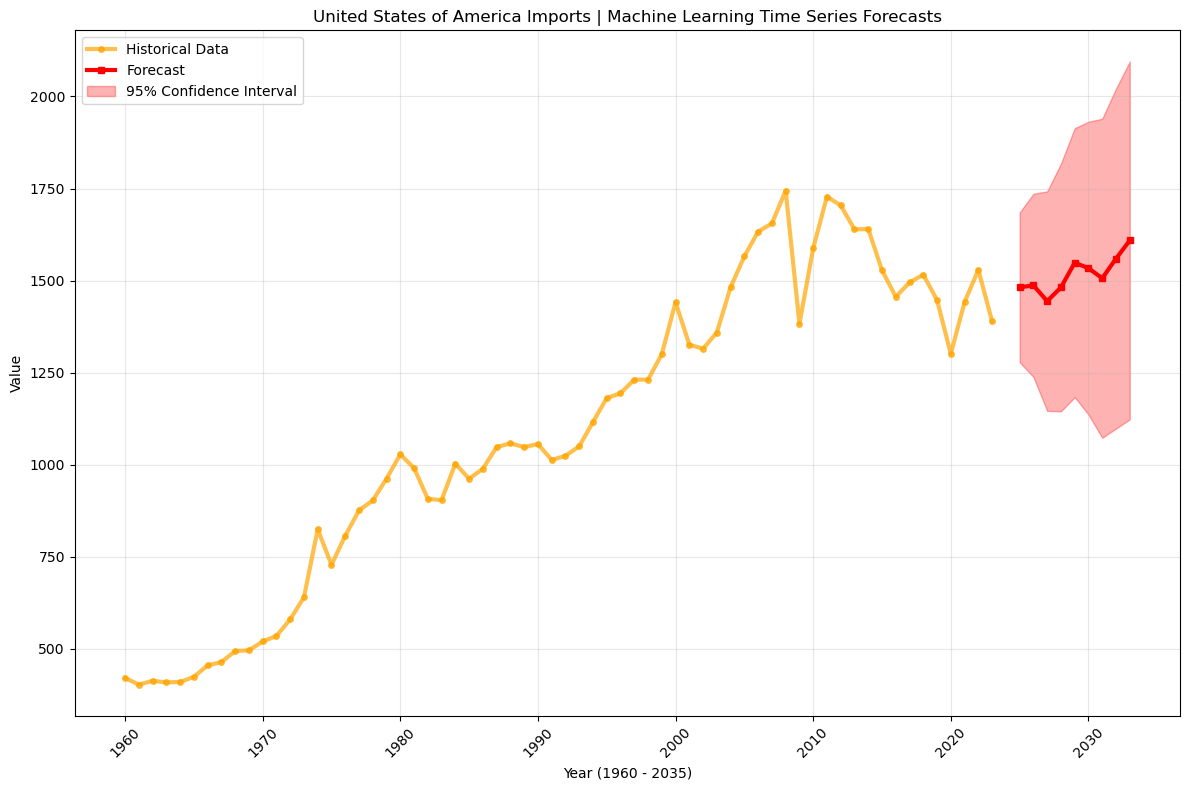

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -361.016
Date:                Fri, 25 Jul 2025   AIC                            734.032
Time:                        18:19:15   BIC                            746.795
Sample:                    01-01-1960   HQIC                           739.043
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1966      0.131     -1.500      0.134      -0.453       0.060
ar.L2         -0.9536      0.124     -7.695      0.000      -1.196      -0.711
ma.L1         -0.9414    107.685     -0.009      0.9

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('United States of America Imports | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA | IMPORTS
    sample_data = {
        1960:4.21, 1961:4.03, 1962:4.13, 1963:4.09, 1964:4.10,
        1965:4.24, 1966:4.55, 1967:4.64, 1968:4.94, 1969:4.96,
        1970:5.20, 1971:5.35, 1972:5.80, 1973:6.40, 1974:8.25,
        1975:7.28, 1976:8.07, 1977:8.76, 1978:9.03, 1979:9.62,
        1980:10.28, 1981:9.91, 1982:9.07, 1983:9.04, 1984:10.03,
        1985:9.62, 1986:9.89, 1987:10.48, 1988:10.58, 1989:10.48,
        1990:10.56, 1991:10.13, 1992:10.24, 1993:10.50, 1994:11.16,
        1995:11.81, 1996:11.94, 1997:12.31, 1998:12.31, 1999:13.00,
        2000:14.41, 2001:13.26, 2002:13.15, 2003:13.59, 2004:14.82,
        2005:15.66, 2006:16.33, 2007:16.55, 2008:17.44, 2009:13.83,
        2010:15.88, 2011:17.28, 2012:17.04, 2013:16.39, 2014:16.40,
        2015:15.28, 2016:14.56, 2017:14.95, 2018:15.16, 2019:14.47,
        2020:13.01, 2021:14.42, 2022:15.29, 2023:13.89, 2024:13.99
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Time Series Forecasting Tool
Loaded 64 data points from 65 input years
Data range: 1960 to 2023
ADF Statistic: -2.1929
p-value: 0.2088
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (2, 1, 0)
AIC: 243.44

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   3.09         -1.79        7.97        
2026   4.47         -0.98        9.92        
2027   4.14         -1.62        9.90        
2028   3.42         -2.80        9.64        
2029   3.43         -3.37        10.22       
2030   3.76         -3.50        11.03       
2031   3.83         -3.81        11.48       
2032   3.69         -4.32        11.70       
2033   3.63         -4.77        12.02       
2034   nan          nan          nan         


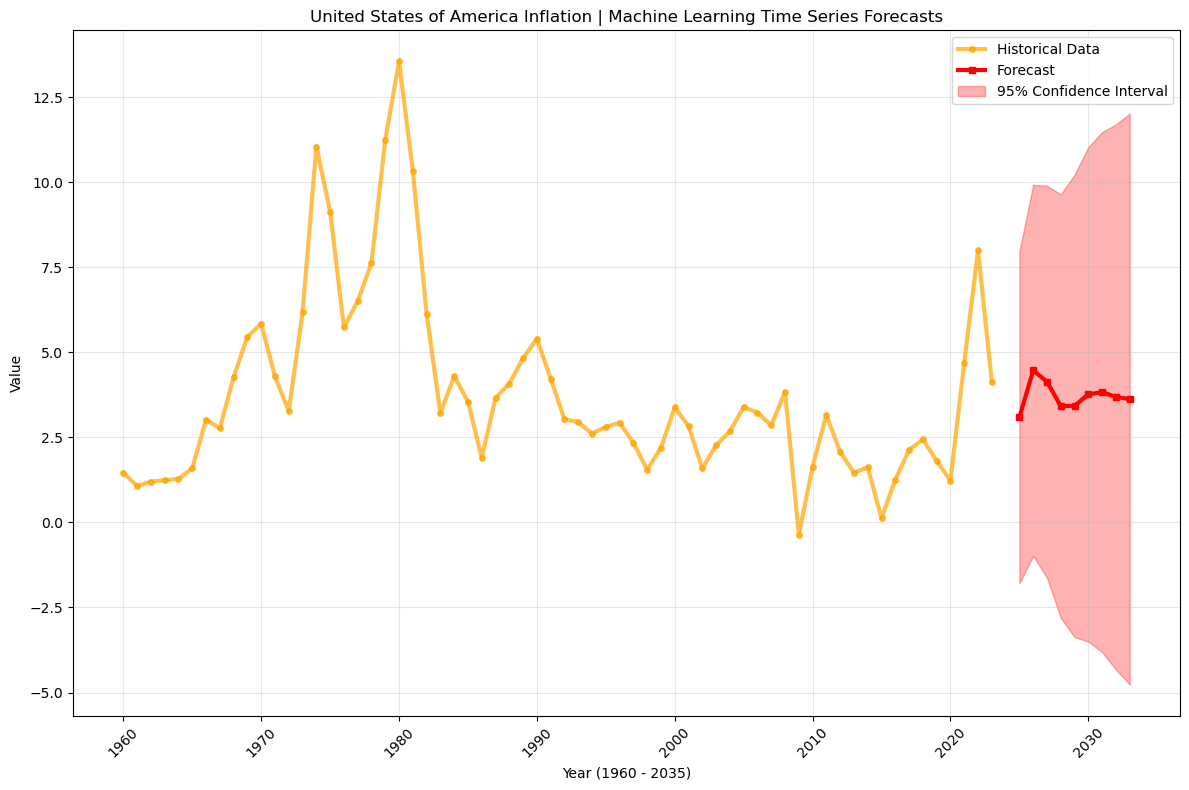

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -118.722
Date:                Fri, 25 Jul 2025   AIC                            243.444
Time:                        18:29:05   BIC                            249.873
Sample:                    01-01-1960   HQIC                           245.972
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2089      0.084      2.490      0.013       0.044       0.373
ar.L2         -0.4684      0.116     -4.050      0.000      -0.695      -0.242
sigma2         2.5165      0.374      6.724      0.0

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('United States of America Inflation | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA INFLATION
    sample_data = {
        1960:1.46, 1961:1.07, 1962:1.20, 1963:1.24, 1964:1.28, 
        1965:1.59, 1966:3.02, 1967:2.77, 1968:4.27, 1969:5.46, 
        1970:5.84, 1971:4.29, 1972:3.27, 1973:6.18, 1974:11.05,
        1975:9.14, 1976:5.74, 1977:6.50, 1978:7.63, 1979:11.25,
        1980:13.55, 1981:10.33, 1982:6.13, 1983:3.21, 1984:4.30,
        1985:3.55, 1986:1.90, 1987:3.66, 1988:4.08, 1989:4.83, 
        1990:5.40, 1991:4.23, 1992:3.03, 1993:2.95, 1994:2.61, 
        1995:2.81, 1996:2.93, 1997:2.34, 1998:1.55, 1999:2.19, 
        2000:3.38, 2001:2.83, 2002:1.59, 2003:2.27, 2004:2.68, 
        2005:3.39, 2006:3.23, 2007:2.85, 2008:3.84, 2009:-0.36, 
        2010:1.64, 2011:3.16, 2012:2.07, 2013:1.46, 2014:1.62, 
        2015:0.12, 2016:1.26, 2017:2.13, 2018:2.44, 2019:1.81, 
        2020:1.23, 2021:4.70, 2022:8.00, 2023:4.12, 2024:2.95
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Time Series Forecasting Tool
Loaded 34 data points from 34 input years
Data range: 1990 to 2023
ADF Statistic: -0.1468
p-value: 0.9446
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (0, 2, 1)
AIC: 216.67

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   119.23       101.09       137.38      
2026   121.47       98.93        144.01      
2027   123.71       97.32        150.09      
2028   125.95       96.05        155.84      
2029   128.18       95.01        161.36      
2030   130.42       94.13        166.71      
2031   132.66       93.38        171.94      
2032   134.90       92.73        177.06      
2033   137.13       92.16        182.11      
2034   nan          nan          nan         


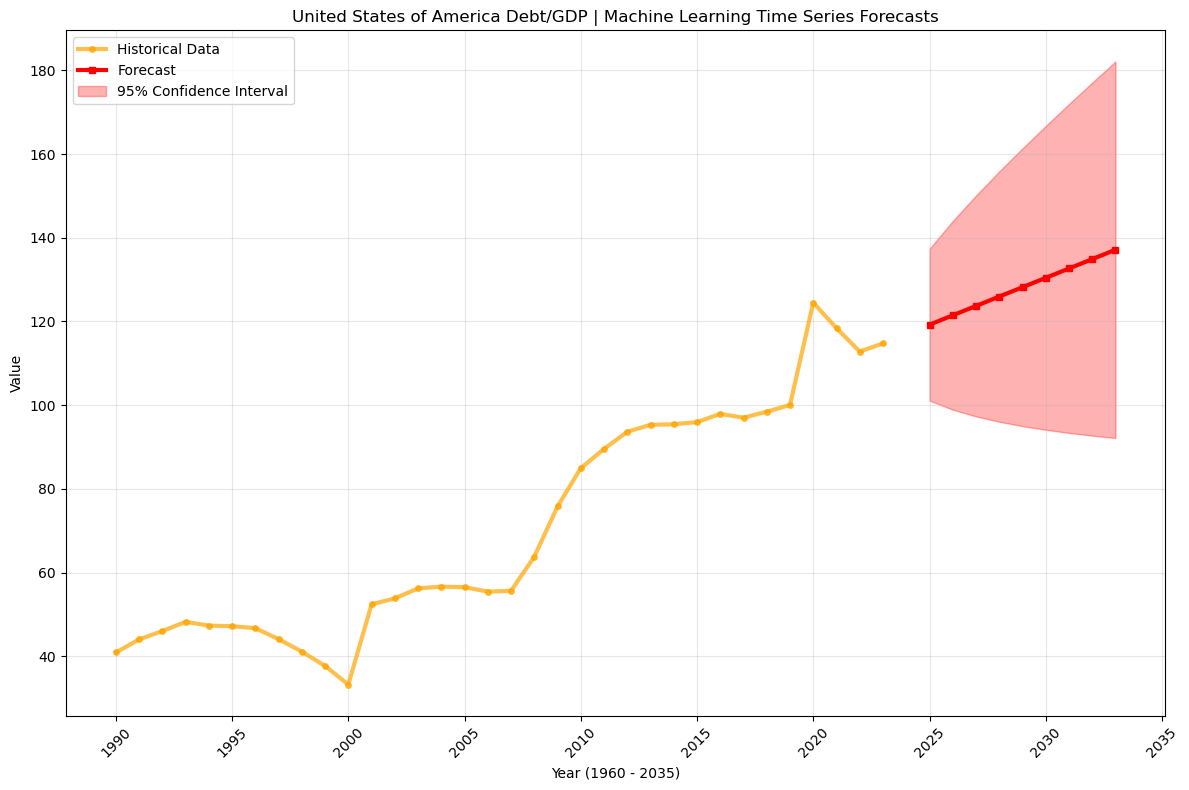

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -106.336
Date:                Sat, 26 Jul 2025   AIC                            216.673
Time:                        07:30:56   BIC                            219.604
Sample:                    01-01-1990   HQIC                           217.645
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998     23.289     -0.043      0.966     -46.646      44.647
sigma2        40.4190    937.398      0.043      0.966   -1796.848    1877.686
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('United States of America Debt/GDP | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA Debt/GDP
    sample_data = {
        1990:40.93,1991:44.06,1992:46.05,1993:48.25,1994:47.35,
        1995:47.21,1996:46.74,1997:44.12,1998:41.13,1999:37.73,
        2000:33.27,2001:52.44,2002:53.86,2003:56.25,2004:56.66,
        2005:56.54,2006:55.47,2007:55.66,2008:63.82,2009:75.84,
        2010:84.96,2011:89.55,2012:93.65,2013:95.32,2014:95.45,
        2015:95.96,2016:97.93,2017:97.02,2018:98.45,2019:100.06,
        2020:124.51,2021:118.40,2022:112.82,2023:114.76
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()

Time Series Forecasting Tool
Loaded 33 data points from 34 input years
Data range: 1991 to 2023
ADF Statistic: -2.1627
p-value: 0.2201
⚠ Series is non-stationary, will difference the data
Finding optimal ARIMA parameters...
Best ARIMA parameters: (0, 1, 0)
AIC: 108.54

FORECAST RESULTS (2026-2035)
Year   Forecast     Lower 95%    Upper 95%   
------------------------------------------------------------
2025   3.64         0.10         7.18        
2026   3.64         -0.70        7.98        
2027   3.64         -1.37        8.65        
2028   3.64         -1.96        9.24        
2029   3.64         -2.50        9.78        
2030   3.64         -2.99        10.27       
2031   3.64         -3.45        10.73       
2032   3.64         -3.88        11.16       
2033   3.64         -4.28        11.56       
2034   nan          nan          nan         


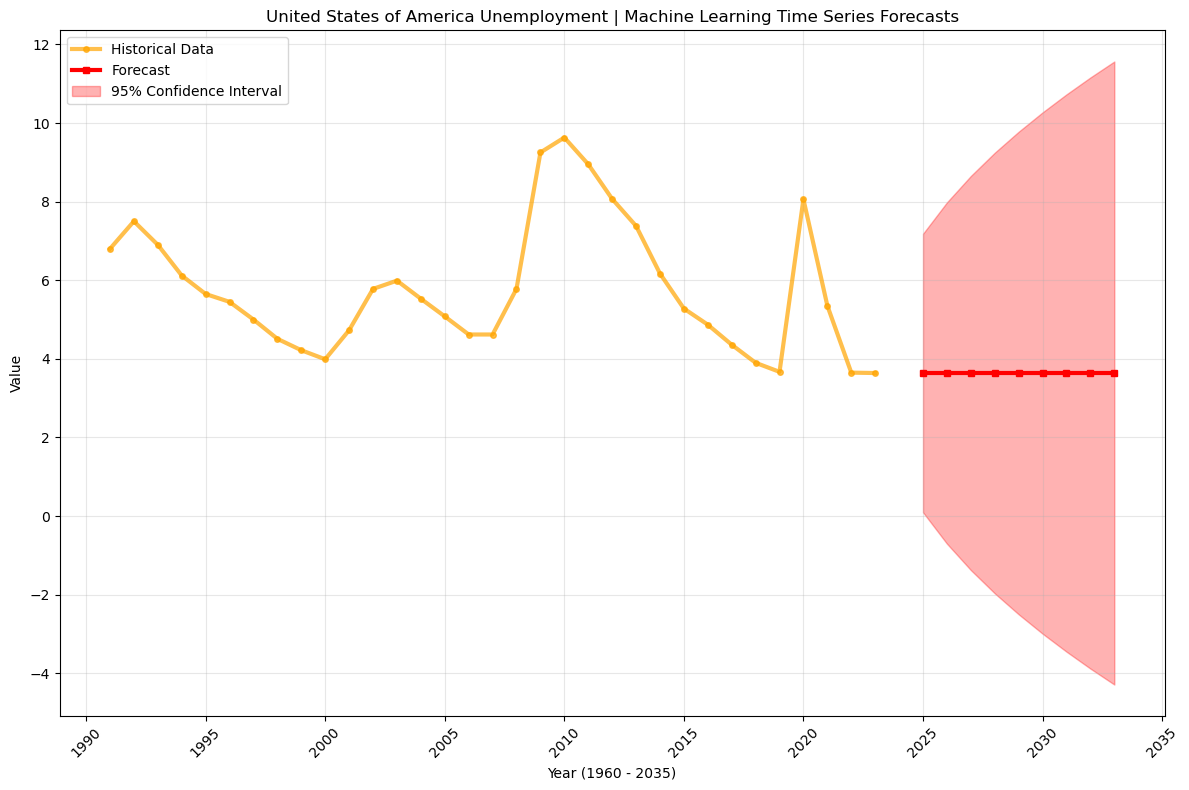

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -53.272
Date:                Sat, 26 Jul 2025   AIC                            108.543
Time:                        07:31:08   BIC                            110.009
Sample:                    01-01-1991   HQIC                           109.029
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.6349      0.239      6.849      0.000       1.167       2.103
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.44
Prob(Q):                              0.77   Pr

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesForecaster:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        
    def load_data(self, data_dict):
        """
        Load data from dictionary format: {year: value}
        Automatically handles missing years between 1960-2024
        """
        # Creating full range and fill missing years with NaN
        full_range = range(1960, 2024)
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Converting to pandas Series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Removing NaN values for modeling
        self.clean_data = self.data.dropna()
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        
    def check_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.clean_data)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("⚠ Series is non-stationary, will difference the data")
            return False
    
    def auto_arima(self, max_p=3, max_d=2, max_q=3):
        """
        Automatically find best ARIMA parameters using AIC
        """
        best_aic = np.inf
        best_params = None
        best_model = None
        
        print("Finding optimal ARIMA parameters...")
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.clean_data, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model
                            
                    except Exception:
                        continue
        
        if best_model is None:
            # Fallback to simple ARIMA(1,1,1)
            print("Using fallback ARIMA(1,1,1)")
            model = ARIMA(self.clean_data, order=(1, 1, 1))
            self.model = model.fit()
            self.best_params = (1, 1, 1)
        else:
            self.model = best_model
            self.best_params = best_params
            
        print(f"Best ARIMA parameters: {self.best_params}")
        print(f"AIC: {self.model.aic:.2f}")
        
    def forecast_future(self, years_ahead=10):
        """Generate forecasts for specified years ahead"""
        if self.model is None:
            raise ValueError("Model not fitted. Call auto_arima() first.")
            
        # Forecasting with confidence intervals
        forecast_result = self.model.forecast(steps=years_ahead)
        conf_int = self.model.get_forecast(steps=years_ahead).conf_int()
        
        # Creating forecast for dates 2026-2035
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 2, last_year + 2 + years_ahead)  # Skip 2025
        forecast_index = pd.to_datetime([f'{year}-01-01' for year in forecast_years])
        
        # Storing forecast results
        self.forecast = pd.Series(forecast_result, index=forecast_index)
        self.forecast_lower = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
        self.forecast_upper = pd.Series(conf_int.iloc[:, 1], index=forecast_index)
        
        return self.forecast
    
    def plot_results(self, figsize=(12, 8)):
        """Plot historical data and forecasts"""
        plt.figure(figsize=figsize)
        
        # Plot historical data
        plt.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='orange', alpha=0.7,linewidth=3, markersize=4)
        
        # Ploting forecasts
        if self.forecast is not None:
            plt.plot(self.forecast.index, self.forecast.values, 
                    's-', label='Forecast', color='red', linewidth=3, markersize=4)
            
            # Ploting confidence intervals
            plt.fill_between(self.forecast.index, 
                           self.forecast_lower.values,
                           self.forecast_upper.values,
                           alpha=0.3, color='red', label='95% Confidence Interval')
        
        plt.title('United States of America Unemployment | Machine Learning Time Series Forecasts')
        plt.xlabel('Year (1960 - 2035)')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def print_forecast_table(self):
        """Print forecast results in a nice table format"""
        if self.forecast is None:
            print("No forecast available. Run forecast_future() first.")
            return
            
        print("\n" + "="*60)
        print("FORECAST RESULTS (2026-2035)")
        print("="*60)
        print(f"{'Year':<6} {'Forecast':<12} {'Lower 95%':<12} {'Upper 95%':<12}")
        print("-"*60)
        
        for i, year in enumerate(self.forecast.index):
            print(f"{year.year:<6} {self.forecast.iloc[i]:<12.2f} "
                  f"{self.forecast_lower.iloc[i]:<12.2f} {self.forecast_upper.iloc[i]:<12.2f}")
        
        print("="*60)
        
    def get_model_summary(self):
        """Print model summary statistics"""
        if self.model is not None:
            print(self.model.summary())


if __name__ == "__main__":
    # DATA: UNITED STATES OF AMERICA Unemployment
    sample_data = {
       1991:6.80,1992:7.50,1993:6.90,1994:6.12,1995:5.65,
       1996:5.45,1997:5.00,1998:4.51,1999:4.22,2000:3.99,
       2001:4.73,2002:5.78,2003:5.99,2004:5.53,2005:5.08,
       2006:4.62,2007:4.62,2008:5.78,2009:9.25,2010:9.63,
       2011:8.95,2012:8.07,2013:7.38,2014:6.17,2015:5.28,
       2016:4.87,2017:4.36,2018:3.90,2019:3.67,2020:8.06,
       2021:5.35,2022:3.65,2023:3.64,2024:4.11
    }
    
    # Initialize and run forecaster
    forecaster = TimeSeriesForecaster()
    
    print("Time Series Forecasting Tool")
    print("="*50)
    
    # Loading data
    forecaster.load_data(sample_data)
    
    # Checking stationarity
    forecaster.check_stationarity()
    
    # Finding best model
    forecaster.auto_arima()
    
    # Generating forecasts for 2026-2035
    forecast = forecaster.forecast_future(years_ahead=10)
    
    # Displaying results
    forecaster.print_forecast_table()
    
    # Ploting results
    forecaster.plot_results()
    
    #Detailed model summary
    forecaster.get_model_summary()